In [2]:
# Fetch the CTG data set.
!wget https://www.cse.chalmers.se/~richajo/dit866/data/CTG.csv

--2024-01-17 13:18:47--  https://www.cse.chalmers.se/~richajo/dit866/data/CTG.csv
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307385 (300K) [text/plain]
Saving to: ‘CTG.csv.6’

CTG.csv.6           100%[===================>] 300.18K  --.-KB/s    in 0.04s   

2024-01-17 13:18:47 (7.78 MB/s) - ‘CTG.csv.6’ saved [307385/307385]



### Task 2. Reading the data

This code was taken from the assignment description and reads the data into training and testing variables.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the CSV file.
data = pd.read_csv('CTG.csv', skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)


# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]


Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [4]:
# Take a peak at the data.
X.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
658,130.0,1.0,0.0,3.0,0.0,0.0,0.0,24.0,1.2,12.0,...,35.0,120.0,155.0,1.0,0.0,134.0,133.0,135.0,1.0,0.0
1734,134.0,9.0,1.0,8.0,5.0,0.0,0.0,59.0,1.2,0.0,...,109.0,80.0,189.0,6.0,0.0,150.0,146.0,150.0,33.0,0.0
1226,125.0,1.0,0.0,4.0,0.0,0.0,0.0,43.0,0.7,31.0,...,21.0,120.0,141.0,0.0,0.0,131.0,130.0,132.0,1.0,0.0
1808,143.0,0.0,0.0,1.0,0.0,0.0,0.0,69.0,0.3,6.0,...,27.0,132.0,159.0,1.0,0.0,145.0,144.0,146.0,1.0,0.0
825,152.0,0.0,0.0,4.0,0.0,0.0,0.0,62.0,0.4,59.0,...,25.0,136.0,161.0,0.0,0.0,159.0,156.0,158.0,1.0,1.0


### Step 2. Training the baseline classifier

We begin by using a dummy classifier as a baseline for our upcomping implementation. A higher aggregated result means that the accuracy is higher, so we want to find a classifier with a good aggregated result.

In [5]:
from sklearn.dummy import DummyClassifier

# Create dummy classifier.
clf = DummyClassifier(strategy='most_frequent')

In [6]:
from sklearn.model_selection import cross_val_score

# Perform cross validation.
dummy_cross_val = cross_val_score(clf, Xtrain, Ytrain)

Once we have cross validated the scores, we now aggregate the results to make it comparable to other classifiers. We use the mean to find a good representation of the results.

In [7]:
import numpy as np


# Returns the aggregation of an array of numbers.
def aggregate(arr: np.ndarray):
    # return the mean of the array
    return np.mean(arr)


dummy_aggr = aggregate(dummy_cross_val)
dummy_aggr

0.7805882352941176

### Step 3. Trying out different classifiers

In this step, we use a number of classifiers and compare the aggregated results using the `aggregate()` function defined above. We choose to scale the data to help the linear classifiers converge [[1]](https://scikit-learn.org/stable/modules/preprocessing.html).

In [8]:
from sklearn.preprocessing import StandardScaler

# Scale the data.
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [9]:
import sklearn.tree as tree
import sklearn.ensemble as ensemble
import sklearn.linear_model as linear
import sklearn.svm as svm
import sklearn.neural_network as nn

# Run cross validation on decision tree, random forest, gradient boosting, perceptron, logistic regression, linear SVC and MLP.
tree_clf = tree.DecisionTreeClassifier()
tree_cross_val = cross_val_score(tree_clf, Xtrain, Ytrain)

forest_clf = ensemble.RandomForestClassifier()
forest_cross_val = cross_val_score(forest_clf, Xtrain, Ytrain)

gb_clf = ensemble.GradientBoostingClassifier(max_depth=10)
gb_cross_val = cross_val_score(gb_clf, Xtrain, Ytrain)

perceptron_clf = linear.Perceptron()
perceptron_cross_val = cross_val_score(perceptron_clf, Xtrain, Ytrain)

logreg_clf = linear.LogisticRegression()
logreg_cross_val = cross_val_score(logreg_clf, Xtrain, Ytrain)

linsvc_clf = svm.LinearSVC(dual=False)
linsvc_cross_val = cross_val_score(linsvc_clf, Xtrain, Ytrain)

mlp_clf = nn.MLPClassifier(max_iter=3000, hidden_layer_sizes=(100, 100), solver='adam')
mlp_cross_val = cross_val_score(mlp_clf, Xtrain, Ytrain)

# Aggregate the results.
tree_aggr = aggregate(tree_cross_val)
forest_aggr = aggregate(forest_cross_val)
gb_aggr = aggregate(gb_cross_val)
perceptron_aggr = aggregate(perceptron_cross_val)
logreg_aggr = aggregate(logreg_cross_val)
linsvc_aggr = aggregate(linsvc_cross_val)
mlp_aggr = aggregate(mlp_cross_val)

# Print the results.
print('Baseline:\n---------')
print('Dummy:', dummy_aggr)

print('\nTree-based:\n-----------')
print('Decision tree:', tree_aggr)
print('Random forest:', forest_aggr)
print('Gradient boost:', gb_aggr)

print('\nLinear:\n-------')
print('Perceptron:', perceptron_aggr)
print('Logistic regression:', logreg_aggr)
print('Linear SVC:', linsvc_aggr)

print('\nNeural net:\n-----------')
print('MLP:', mlp_aggr)

Baseline:
---------
Dummy: 0.7805882352941176

Tree-based:
-----------
Decision tree: 0.9205882352941176
Random forest: 0.9370588235294118
Gradient boost: 0.9470588235294117

Linear:
-------
Perceptron: 0.8729411764705883
Logistic regression: 0.891764705882353
Linear SVC: 0.8905882352941177

Neural net:
-----------
MLP: 0.9376470588235295


### Step 4. Choosing the best classifier

With the cross validation results finished and aggregated, we choose the best performing one based on their scores. The winner here is gradient boost, and [`report.md`](./report.md) contains more discussion.

In [10]:
from sklearn.metrics import accuracy_score

# Candidate models and their aggregation results.
candidates = {
    'Decision tree': (tree_clf, tree_aggr),
    'Random forest': (forest_clf, forest_aggr),
    'Gradient boost': (gb_clf, gb_aggr),
    'Perceptron': (perceptron_clf, perceptron_aggr),
    'Logistic regression': (logreg_clf, logreg_aggr),
    'Linear SVC': (linsvc_clf, linsvc_aggr),
    'MLP': (mlp_clf, mlp_aggr)
}

# Find the best model.
best = None
for candidate in candidates:
    if best is None or candidates[candidate][1] > candidates[best][1]:
        best = candidate

print('Best model:', best)
best_clf = candidates[best][0]
best_clf.fit(Xtrain, Ytrain)
Yguess = best_clf.predict(Xtest)
print('Accuracy:', accuracy_score(Ytest, Yguess))

Best model: Gradient boost
Accuracy: 0.9295774647887324


## Task 2. Decision trees

The code for this task was provided by the assignment description, and was taken from this [page](https://www.cse.chalmers.se/~richajo/dit866/lectures/l1/Lecture%201.html).

In [11]:
class DecisionTreeLeaf:
    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(
            self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter + 1, node_id

    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

In [12]:
class DecisionTreeBranch:
    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(
            graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(
            graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box',
                   fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter + 1, node_id

In [ ]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod


class DecisionTree(ABC, BaseEstimator):
    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth

    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)
        self.root = self.make_tree(X, Y, self.max_depth)

    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph

    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)

        # This is the recursive training 

    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))

        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth - 1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth - 1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)

    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:, feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]

    # The following three methods need to be implemented by the classification and regression subclasses.

    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

In [14]:
from collections import Counter


class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion

    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]

    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1

    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):
        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n - 1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i + 1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i + 1, low_distr, n - i - 1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5 * (X_sorted[max_i] + X_sorted[max_i + 1])
        return max_score, feature, split_point


def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high


def entropy(distr):
    n = sum(distr.values())
    ps = [n_i / n for n_i in distr.values()]
    return -sum(p * np.log2(p) if p > 0 else 0 for p in ps)


def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low * entropy(low_distr) + n_high * entropy(high_distr)) / (n_low + n_high)


def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i / n for n_i in distr.values()]
    return 1 - sum(p ** 2 for p in ps)


def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low * gini_impurity(low_distr) + n_high * gini_impurity(high_distr)) / (n_low + n_high)

### Creating and tuning the decision tree

With the copy pasted code settled, we can use the `TreeClassifier` class and fine tune it to bead the gradient boost classifier.

In [19]:
best = (0, 0)
for depth in range(1, 10):
    clf = TreeClassifier(max_depth=depth, criterion='gini')
    aggr = aggregate(cross_val_score(clf, Xtrain, Ytrain))
    if aggr > best[1]:
        best = (depth, aggr)
best

(7, 0.9341176470588234)

In [16]:
depth = best[0]
clf = TreeClassifier(max_depth=depth, criterion='gini')
clf.fit(Xtrain, Ytrain)
Yguess = clf.predict(Xtest)
print('Accuracy:', accuracy_score(Ytest, Yguess))


Accuracy: 0.9178403755868545


### Drawing the tree with graphviz

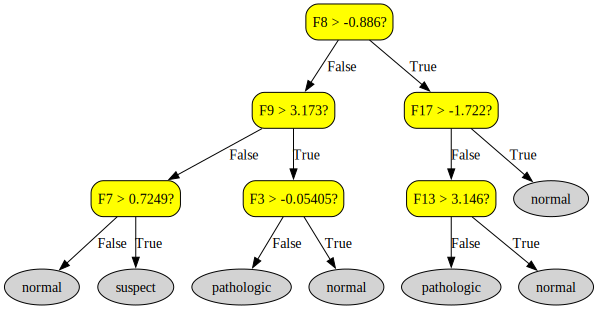

In [18]:
clf = TreeClassifier(max_depth=3, criterion='gini')
clf.fit(Xtrain, Ytrain)
Yguess = clf.predict(Xtest)
clf.draw_tree()

## Task 3

We will now predict apartment prices using regression.

In [ ]:
# !wget https://www.cse.chalmers.se/~richajo/dit866/data/sberbank.csv

### Reading and preprocessing the data

With the above `wget` to the dataset we download the data. Then we use the provided snippet to read it preprocess it.

In [23]:
# Read the CSV file using Pandas.
alldata = pd.read_csv("sberbank.csv")


# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])


alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [24]:
# Sanity check.
X.head()

,year,full_sq,life_sq,floor,num_room,kitch_sq,full_all
25252,2014,61,32.0,8.0,2.0,13.0,247469
9943,2013,43,20.0,10.0,1.0,8.0,68630
18040,2014,56,30.0,11.0,2.0,8.0,78507
8625,2013,54,32.0,10.0,2.0,9.0,26943
13495,2013,38,20.0,2.0,1.0,8.0,132349


We train a baseline dummy regressor (which always predicts the same value) and evaluate it in a cross-validation setting.

This example looks quite similar to the classification example above. The main differences are (a) that we are predicting numerical values, not symbolic values; (b) that we are evaluating using the mean squared error metric, not the accuracy metric that we used to evaluate the classifiers.

In [38]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

m1 = DummyRegressor()
aggregate(cross_val_score(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error'))

-0.38925247260237567

Using the provided classifiers, we find the best regression model.

In [91]:
# Importing required libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Creating dictionary of regressors with their parameters
regressors = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(max_depth=7, criterion="friedman_mse"),
    "Gradient Boosting": GradientBoostingRegressor(criterion="friedman_mse"),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(200, 200), activation='relu', solver='adam',
                                   learning_rate_init=0.003, max_iter=20000, early_stopping=True)
}

# Finding the best model
best_score = float('-inf')
best_name = None

for name, reg in regressors.items():
    score = aggregate(cross_val_score(reg, Xtrain, Ytrain, scoring='neg_mean_squared_error'))
    print(f"name: {name} score: {score}")
    if score > best_score:
        best_score = score
        best_name = name

# Output the best model
print(f"Best Model: {best_name} with score: {best_score}")


name: Neural Network score: -7.325481419038612
Best Model: Neural Network with score: -7.325481419038612


# Task 4. Decision trees for regression



In [93]:
import numpy as np
from sklearn.base import RegressorMixin
import matplotlib.pyplot as plt


class TreeRegressor(DecisionTree, RegressorMixin):
    def __init__(self, max_depth: int = 10, criterion: str = "mse", var_thresh: float = 0.1):
        super().__init__(max_depth)
        self.var_thresh = var_thresh
        self.criterion = criterion

    def get_default_value(self, Y):
        return np.mean(Y)

    def is_homogeneous(self, Y):
        return np.var(Y) < self.var_thresh

    def variance(self, Y):
        n = len(Y)
        sum_x = np.sum(Y)
        sum_x2 = np.sum([x ** 2 for x in Y])
        return (1 / n) * sum_x2 - (1 / (n ** 2)) * (sum_x ** 2)

    def best_split(self, X, Y, feature):
        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        max_score = -np.inf
        max_i = None

        # precompute total sums and variance
        total_y = np.sum(Y)
        total_y2 = np.sum([x ** 2 for x in Y])
        total_variance = (total_y2 - (total_y ** 2) / n) / n
        low_sum, low_sq_sum, high_sum, high_sq_sum = 0, 0, total_y, total_y2

        for i in range(0, n - 1):
            # keep track of all sums 
            y_i = Y_sorted[i]
            low_sum += y_i
            low_sq_sum += y_i ** 2
            high_sum -= y_i
            high_sq_sum -= y_i ** 2

            # continue until its different 
            x_i, x_next = X_sorted[i], X_sorted[i + 1]
            if x_i == x_next:
                continue

            # look at the variance difference
            low_n, high_n = i + 1, n - i - 1
            low_variance = (low_sq_sum - (low_sum ** 2) / low_n) / low_n
            high_variance = (high_sq_sum - (high_sum ** 2) / high_n) / high_n

            variance_reduction = total_variance - (low_variance * low_n + high_variance * high_n) / n

            if variance_reduction > max_score:
                max_score = variance_reduction
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5 * (X_sorted[max_i] + X_sorted[max_i + 1])
        return max_score, feature, split_point

    def fit(self, X, Y):
        super().fit(X, Y)

In [120]:
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1 * np.random.normal(size=n)
    X = x.reshape(n, 1)  # X needs to be a 2-dimensional matrix
    return X, Y

In [129]:
import numpy as np
from sklearn.metrics import mean_squared_error

train_scores = []
test_scores = []
for depth in range(0, 12):
    reg = TreeRegressor(max_depth=depth)
    reg.fit(Xtrain, Ytrain)

    Ypred_train = reg.predict(Xtrain)
    score = mean_squared_error(Ytrain, Ypred_train)
    train_scores.append(score)

    Ypred_test = reg.predict(Xtest)
    score = mean_squared_error(Ytest, Ypred_test)
    test_scores.append(score)


[0.4028398414133475, 0.34098250711388134, 0.3116427403885958, 0.30188395972140913, 0.29310031188060437, 0.2908261342315253, 0.28643634372540716, 0.2903456812456766, 0.29752351177668007, 0.30409588202870064, 0.31247020767405703, 0.319628838789046]
[0.3891468647585388, 0.3263543480100574, 0.30042490282992007, 0.28927232915183554, 0.2807451934658121, 0.2742861310363099, 0.2667434009364825, 0.2580975870702128, 0.24871134720458812, 0.2399212618132105, 0.22830762290316792, 0.21575688242870109]


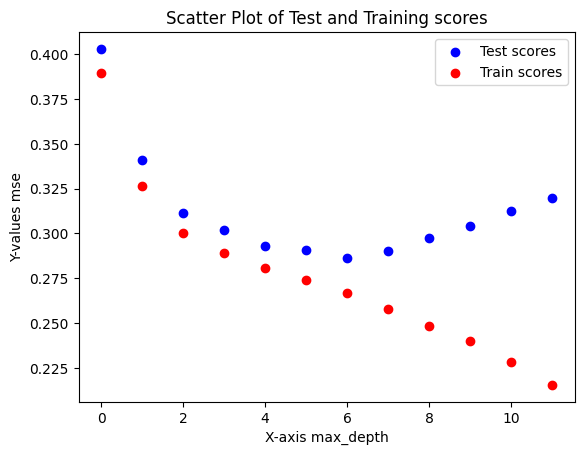

In [130]:
plt.scatter([i for i in range(12)], test_scores, color='blue', label='Test scores')
plt.scatter([i for i in range(12)], train_scores, color='red', label='Training scores')
plt.xlabel('max_depth')
plt.ylabel('mse')
plt.title('Scatter Plot of Test and Training scores')
plt.legend()

# Show plot
plt.show()